# Pipeline

In [1]:
from train_pipeline import train

import os
import torch
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf


def load_cfg(overrides=()):
    # with initialize_config_dir(config_dir="/app/notebooks/draft_02/conf"):
    with initialize(version_base=None, config_path="./conf"):
        cfg = compose(config_name='config', overrides=list(overrides))
        return cfg

from IPython.display import clear_output

cfg = load_cfg(overrides=[
    "+exp=04_parallel",
    "model.model_configs=[{hidden_layers: [32, 16]}]",
    "+device=cuda:0",
])

print(OmegaConf.to_yaml(cfg))

image: tokyo512.png
image_dir: ../../data
image_W: 512
use_wandb: true
is_debug: false
total_steps: 3000
random_seed:
- 0
- 1
- 2
model:
  _target_: spellbook.parallel.ParallelSplitNet
  encoding_size: 64
  model_configs:
  - hidden_layers:
    - 32
    - 16
logging:
  logger:
    _target_: spellbook.logging.wandb.WandbLogger
    project: 01_splitnet__${image}
  steps_till_summary: 500
  experiment_name: splitnet
optimizer:
  _target_: torch.optim.AdamW
  weight_decay: 0.0
  lr: 0.0001
device: cuda:0



In [2]:
def U(*shape, r=1):
    x = torch.rand(*shape)
    
    x = (x-0.5)*(2*r)
    return x

In [3]:
cfg.model

{'_target_': 'spellbook.parallel.ParallelSplitNet', 'encoding_size': 64, 'model_configs': [{'hidden_layers': [32, 16]}]}

In [4]:
from spellbook.parallel import ParallelSplitNet

In [31]:
omegas = [[2.689339192708333, 16.50197957356771, 6.805110168457031, 6.799144490559896],
 [8.467052205403645, 42.76984456380208, 12.20421142578125, 14.096522013346354]]

In [65]:
model_kwargs = {
    'encoding_size': 64, 
    'out_features': 3,
    'model_configs': [
        {
            'hidden_layers': [32, 16],
            'm': 1.,
            'omegas': (1.,1,1,1)
        }
    ]
}

model = ParallelSplitNet(**model_kwargs)

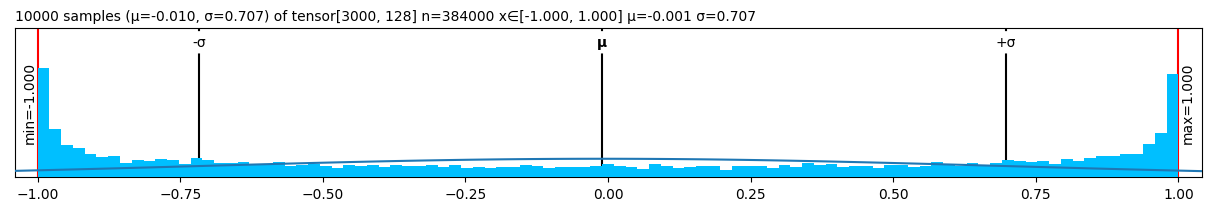

In [66]:
x = U(3_000, 2)
x_enc = model.encoding(x)
x_enc.plt

In [67]:
import numpy as np

In [68]:
if True:
    x_enc_ = x_enc.cpu().clone()
    fan_in = x_enc_.shape[-1]
    gain = 1
    W = U(fan_in, 32, r=np.sqrt(gain/fan_in) )
    
    display( (x_enc_@W).tanh() )

tensor[3000, 32] n=96000 x∈[-0.941, 0.937] μ=0.001 σ=0.357

In [69]:
net = model.networks[0]
net

SimpleSplitNet(
  (net): Sequential(
    (0): SplitLayer(
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (1): SplitLayer(
      (linear): Linear(in_features=32, out_features=64, bias=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (2): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [70]:
from spellbook.splitnet import plot_acts

act_tanh (3000, 32) in [-0.954, 0.938] μ=-0.002 σ=0.355
act_sigmoid (3000, 32) in [0.011, 0.980] μ=0.501 σ=0.208
act_sin (3000, 32) in [-1.000, 1.000] μ=-0.001 σ=0.707
act_cos (3000, 32) in [-1.000, 1.000] μ=0.133 σ=0.696


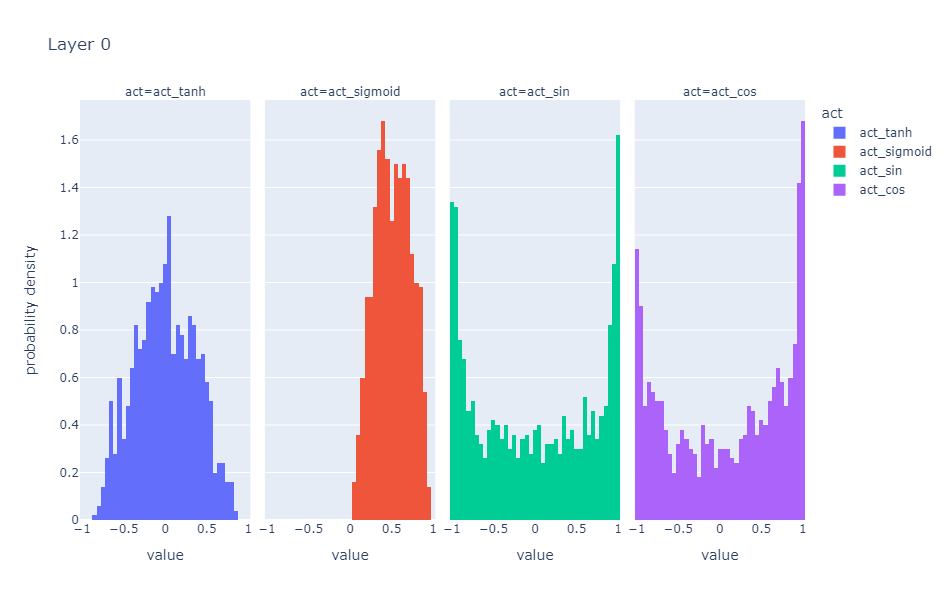

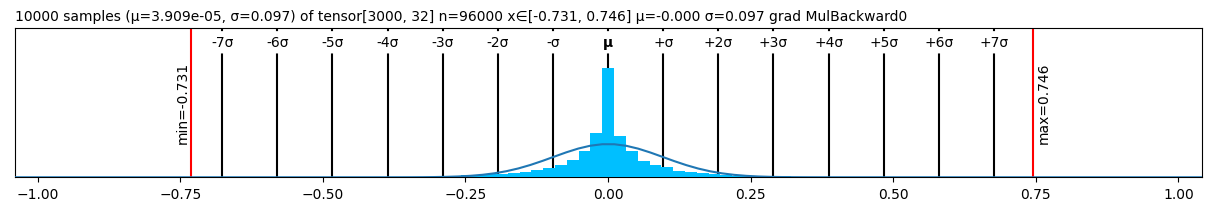

act_tanh (3000, 16) in [-0.253, 0.294] μ=0.000 σ=0.056
act_sigmoid (3000, 16) in [0.351, 0.669] μ=0.500 σ=0.035
act_sin (3000, 16) in [-0.942, 0.994] μ=-0.000 σ=0.270
act_cos (3000, 16) in [0.152, 1.000] μ=0.963 σ=0.055


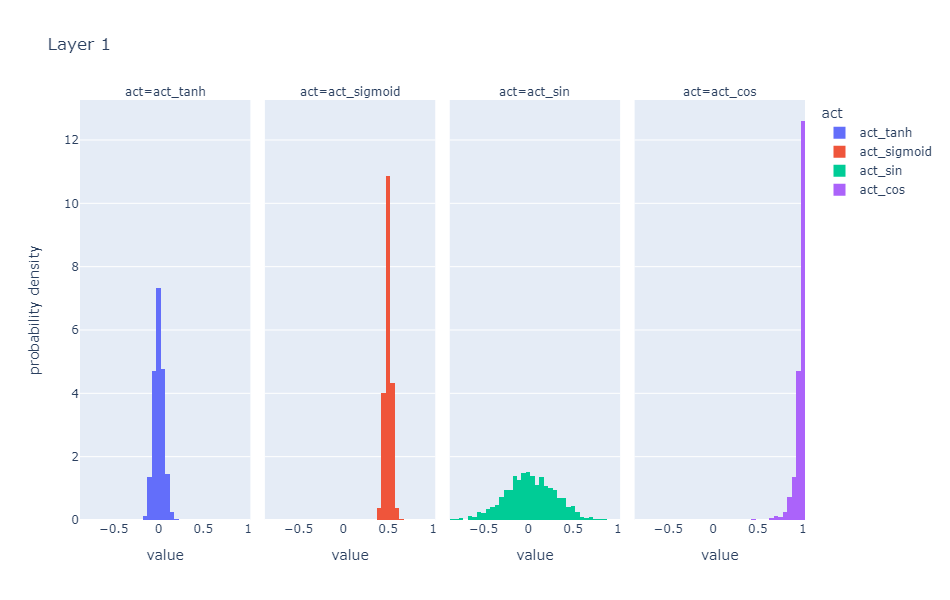

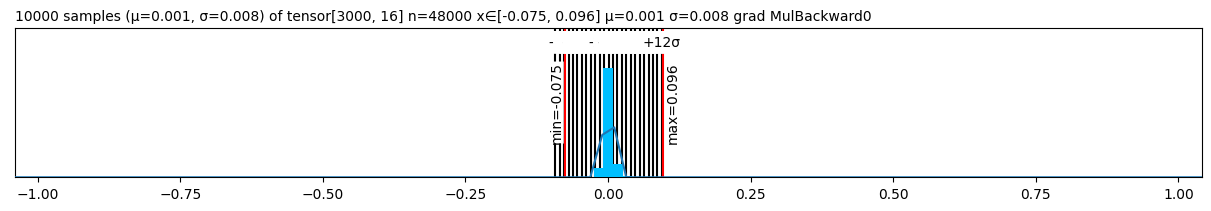

In [71]:
o, intermediate_acts = net.forward_with_activations(x_enc)

for i, (h, acts) in enumerate(intermediate_acts):
    if len(acts) < 1:
        continue
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)

In [72]:
from spellbook.splitnet import plot_distributions

G_tanh (32, 128) in [-0.000, 0.000] μ=0.000 σ=0.000
G_sigmoid (32, 128) in [-0.000, 0.000] μ=0.000 σ=0.000
G_sin (32, 128) in [-0.000, 0.000] μ=-0.000 σ=0.000
G_cos (32, 128) in [-0.000, 0.000] μ=0.000 σ=0.000


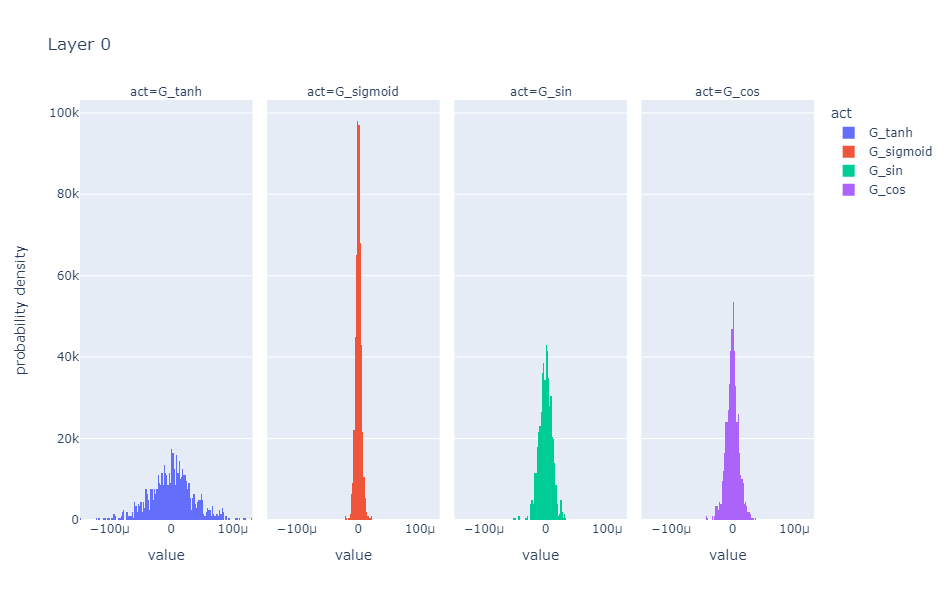

G_tanh (16, 32) in [-0.001, 0.001] μ=0.000 σ=0.000
G_sigmoid (16, 32) in [-0.000, 0.000] μ=0.000 σ=0.000
G_sin (16, 32) in [-0.000, 0.000] μ=-0.000 σ=0.000
G_cos (16, 32) in [-0.000, 0.000] μ=-0.000 σ=0.000


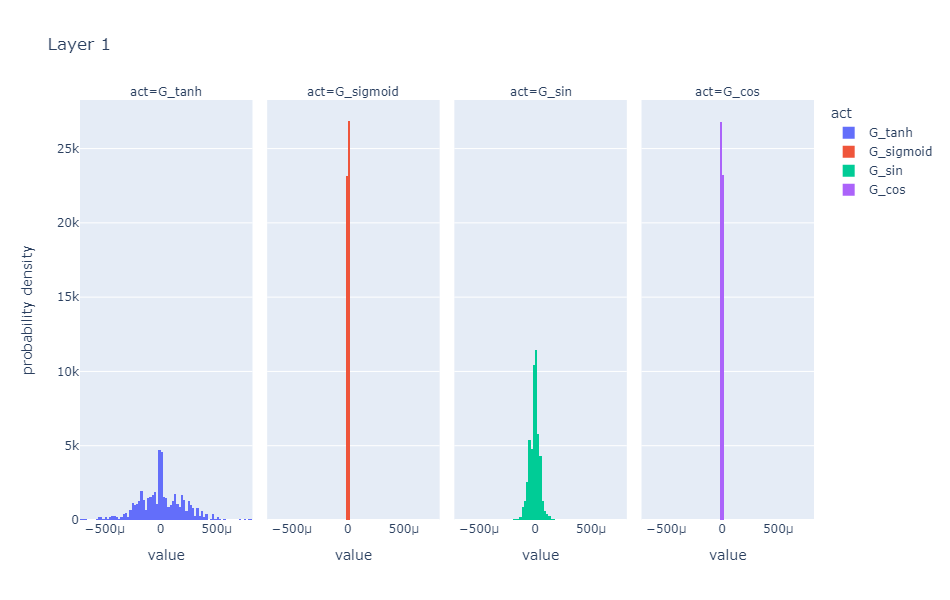

G_linear (3, 16) in [-0.001, 0.001] μ=0.000 σ=0.001


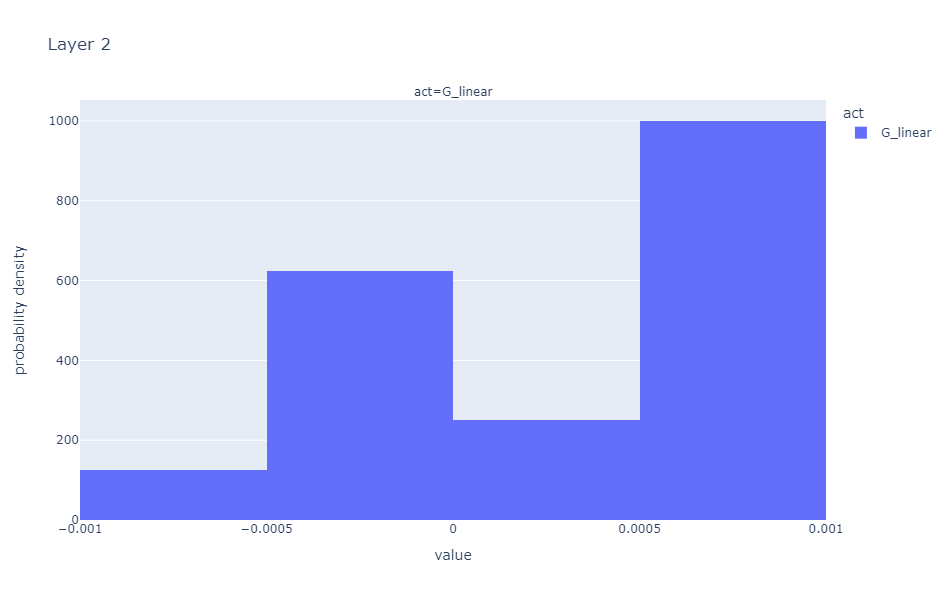

In [73]:
o, intermediate_acts = net.forward_with_activations(x_enc)

o.mean().backward()

for i, layer in enumerate(net.net):
    if hasattr(layer, 'linear'):
        W = layer.linear.weight
        G = W.grad.detach().cpu()

        G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

        plot_data = {
            'G_tanh': G_tanh, 
            'G_sigmoid': G_sigmoid, 
            'G_sin': G_sin, 
            'G_cos': G_cos
        }
    else:
        W = layer.weight
        G = W.grad.detach().cpu()

        plot_data = {
            'G_linear': G, 
        }
    
    # for k,v in plot_data.items():
    #     print(k, v)
    
    plot_distributions(plot_data, title=f'Layer {i}')

In [74]:
layers = {}

proposed_omegas = []
for i, layer in enumerate(net.net):
    if not hasattr(layer, 'linear'):
        continue
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    proposed_omegas_layer = {
        'G_tanh': 1 / G_tanh.std(), 
        'G_sigmoid': 1 / G_sigmoid.std(), 
        'G_sin': 1/ G_sin.std(), 
        'G_cos': 1 / G_cos.std()
    }
    
    # print( [v.item() for v in (proposed_omegas_layer.values())] )
    proposed_omegas.append([v.item() for v in (proposed_omegas_layer.values())])
    
proposed_omegas = np.array(proposed_omegas) / 30
proposed_omegas.tolist()

[[944.8649088541666, 7282.521354166666, 3231.9674479166665, 3198.698177083333],
 [152.54287109375, 36540.0625, 738.4165364583333, 21488.31875]]

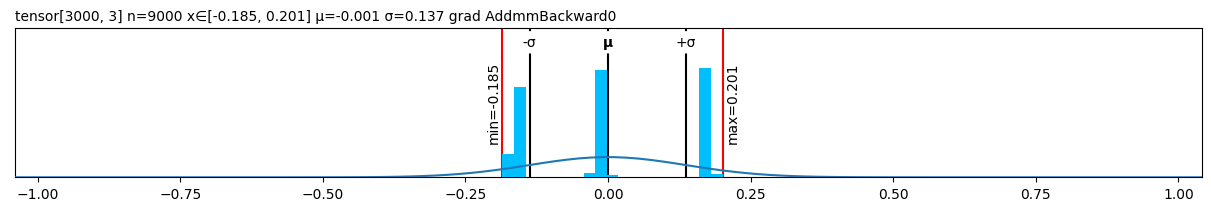

In [75]:
h.plt

In [76]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

# Train

In [77]:
from train_pipeline import *
from tqdm.auto import tqdm
random_seed = 0

In [78]:
model_kwargs = {'encoding_size': 64,
 'out_features': 3,
 'model_configs': [{'hidden_layers': [32, 16],
   'm': 1.0,
   'omegas': omegas}]}

In [81]:
from omegaconf import OmegaConf

TypeError: __init__() takes 1 positional argument but 2 were given

In [80]:
model_kwargs

{'encoding_size': 64,
 'out_features': 3,
 'model_configs': [{'hidden_layers': [32, 16],
   'm': 1.0,
   'omegas': [[2.689339192708333,
     16.50197957356771,
     6.805110168457031,
     6.799144490559896],
    [8.467052205403645,
     42.76984456380208,
     12.20421142578125,
     14.096522013346354]]}]}

Setting seed to 0
+--------------------------------+------------+
|            Modules             | Parameters |
+--------------------------------+------------+
| networks.0.net.0.linear.weight |   16384    |
|  networks.0.net.0.linear.bias  |    128     |
| networks.0.net.1.linear.weight |    2048    |
|  networks.0.net.1.linear.bias  |     64     |
|    networks.0.net.2.weight     |     48     |
|     networks.0.net.2.bias      |     3      |
+--------------------------------+------------+
Total Trainable Params: 18675


  0%|          | 0/500 [00:00<?, ?it/s]

Step 0, Total loss 0.406063


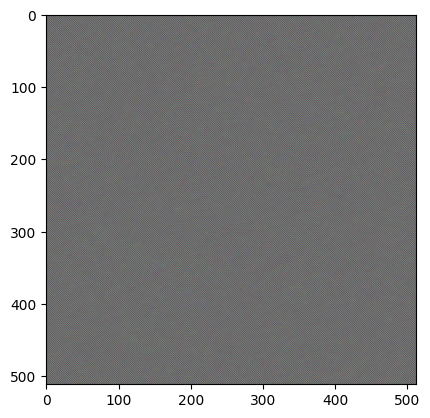

In [79]:
seed_all(random_seed)
print("Setting seed to", random_seed)
is_debug = cfg.get("is_debug")

project = str(cfg.logging.logger.project).replace(".jpg", "_jpg").replace(".png", "_png")

if is_debug:
    project = "DEBUG__" + project

device = cfg["device"]

model_input, ground_truth, H, W = load_data(cfg)
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

out_features = ground_truth.shape[-1]
# model = instantiate(cfg["model"], out_features=out_features)
model = ParallelSplitNet(**model_kwargs)
model.to(device)
net = model.networks[0]

x_enc = model.encoding(model_input)

total_steps = 500
steps_til_summary = cfg.logging["steps_till_summary"]

total_params = count_parameters(model)

optimizer = instantiate(cfg.optimizer, params=net.parameters())

pbar = tqdm ( range(total_steps) )
for step in pbar:
    model_output = net(x_enc)
    # model_output = model(model_input)
    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse
    
    pbar.set_description(f'psnr={psnr:.3f}')

    log_dic = {"step": step, "mse": mse.item(), "psnr": psnr.item()}

    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f}")
        # img_grad_tensor = gradient(model_output, coords)
        # img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output, H, W)
        # img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        # img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = img
        plt.imshow(colage)
        plt.show()


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [ ]:
model_output.plt

In [ ]:
mse

In [ ]:
break

In [ ]:
from spellbook.splitnet import plot_acts

In [ ]:
def init_siren(W, fan_in, omega=30, init_c=24, flic=2, is_first=False):
    if is_first:
        c = flic / fan_in
    else:
        c = np.sqrt(init_c / fan_in) / omega    
    W.uniform_(-c, c)

In [ ]:
from spellbook.splitnet import plot_distributions

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

import os
import math


class SplitLayerOmegas(nn.Module):
    def __init__(self, input_dim, output_dim, m=1.,0 omegas=(1,1,1.,1)):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim * 4)
        self.m = m
        self.omegas = omegas

    def forward(self, x):
        h, acts = self.forward_with_activations(x)
        return h

    def forward_with_activations(self, x):
        preact = self.linear(x)
        preacts = preact.chunk(4, dim=-1)
        preacts = list(preacts)
    
        for i in range(len(preacts)):
            preacts[i] = self.omegas[i] * preacts[i]

        preact_tanh, preact_sigmoid, preact_sin, preact_cos = preacts
        act_tanh, act_sigmoid, act_sin, act_cos = preact_tanh.tanh(), preact_sigmoid.sigmoid(),preact_sin.sin(), preact_cos.cos()
        h = act_tanh * act_sigmoid * act_sin * act_cos
        
        h = h * self.m

        return h, [x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos]

class SplitNetPosEncOmegas(nn.Module):
    def __init__(self, 
                 in_features=2,
                 encoding_size=64,
                 hidden_features=64, 
                 hidden_layers=1, 
                 out_features=1, 
                 outermost_linear=True,
                 m=1.,
                 omegas=(1,1,1.,1),
                 init_fn=None,
                 ):
        super().__init__()
        if not hasattr(m, '__len__'):
            m = [m] * (hidden_layers+2)
            
        is_layerwise_omegas = hasattr(omegas[0], '__len__')
        
        if not is_layerwise_omegas:
            omegas = [omegas] * (hidden_layers+2)
            

        import rff
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=in_features, encoded_size=encoding_size)
        self.net = []

        self.net += [SplitLayerOmegas(encoding_size*2, hidden_features, m=m[0], omegas=omegas[0])]
        self.net += [SplitLayerOmegas(hidden_features, hidden_features, m=m[i+1], omegas=omegas[i+1]) for i in range(hidden_layers)]

        if outermost_linear:
            self.net += [nn.Linear(hidden_features, out_features)]
        else:
            self.net += [SplitLayerOmegas(hidden_features, out_features, omegas=omegas[-1], m=m[-1])]

        self.net = nn.Sequential(*self.net)
        self.outermost_linear = outermost_linear
        self.omegas = omegas
        
        if init_fn == "my_init_02":
            my_init_02(self)
        elif init_fn == 'my_init_03':
            my_init_03(self)
        elif init_fn is not None:
            raise ArgumentError(f"Unknown init_fn: {init_fn}")

    def forward(self, x):
        x = self.encoding(x)
        return self.net(x)

    def forward_with_activations(self, x):
        x = self.encoding(x)
        h = x
        intermediate_acts = []

        for layer in self.net:
            if isinstance(layer, SplitLayerOmegas):
                h, acts = layer.forward_with_activations(h)
            else:
                h = layer(h)
                acts = []

            intermediate_acts.append((h, acts))

        return h, intermediate_acts

    


In [ ]:
mega_omegas = [
    (5/1.323, 15/0.78213, 9/1.2, 10),
    (15, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
    (5, 5, 10, 10),
]

giga_omegas = [
    [0.12014468014240265, 0.6008497476577759, 0.2702421545982361, 0.2616932690143585],
    [0.5118758678436279, 1.9711511135101318, 0.7647950053215027, 0.7527167201042175],
    [2.7775514125823975, 9.462844848632812, 3.237828016281128, 3.223662853240967],
    [18.891096115112305, 60.468223571777344, 18.257936477661133, 18.576128005981445],
    [12.317709922790527, 39.97261428833008, 11.623711585998535, 11.119503021240234],
]

In [ ]:
model_kwargs

In [ ]:
model_kwargs = {'in_features': 2, 
                'encoding_size': 64, 
                'hidden_features': 128, 
                'hidden_layers': 3, 
                'omegas': giga_omegas,
                # 'omegas': (1,1,30,30),
                'outermost_linear': False, 
                'm': 10.
}

# model = instantiate(cfg.model, out_features=1, m=[10, 10, 10,10,10])
model = SplitNetPosEncOmegas(**model_kwargs)
omegas = model.omegas



In [ ]:
# layer.linear.weight.data /= 10

In [ ]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    # if i >= 1:
    #     break

In [ ]:
# x = U(2000, 2)
# o, intermediate_acts = model.forward_with_activations(x)

# for i, (h, acts) in enumerate(intermediate_acts):
#     plot_acts(acts, title=f'Layer {i}')
#     display(h.plt)

In [ ]:
x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

In [ ]:
layers = {}

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    proposed_omegas_layer = {
        'G_tanh': omegas[i][0] / G_tanh.std(), 
        'G_sigmoid': omegas[i][1] / G_sigmoid.std(), 
        'G_sin': omegas[i][2] / G_sin.std(), 
        'G_cos': omegas[i][3] / G_cos.std()
    }
    
    print( [v.item() for v in (proposed_omegas_layer.values())] )

In [ ]:

x = U(2000, 2)
o, intermediate_acts = model.forward_with_activations(x)

o.mean().backward()

for i, layer in enumerate(model.net):
    W = layer.linear.weight
    G = W.grad.detach().cpu()

    G_tanh, G_sigmoid, G_sin, G_cos = G.chunk(4, dim=0)

    plot_data = {
        'G_tanh': G_tanh, 
        'G_sigmoid': G_sigmoid, 
        'G_sin': G_sin, 
        'G_cos': G_cos
    }
    
    # for k,v in plot_data.items():
    #     print(k, v)
    
    plot_distributions(plot_data, title=f'Layer {i}')

    # if i >= 1:
    #     break

In [ ]:
break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'Layer {i} {tuple(G.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

In [ ]:
break

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, (layer) in enumerate(model.net):
    # if i 
    W = layer.linear.weight
    # print(W.grad)
    
    G = W.grad.cpu()
    W = W.cpu()
    print('grad %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(G.shape), G.mean(), G.std(), G.std() / W.std()))
    hy, hx = torch.histogram(G, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    plt.title(f'Layer {i} {tuple(G.shape)}');
    plt.show()


In [ ]:
break

In [ ]:
x_enc = model.encoding(x)
x_enc

In [ ]:
fan_in = 128

In [ ]:
omega=30
init_c=24
flic=2

c = np.sqrt(init_c / fan_in) / omega

In [ ]:
W = torch.zeros(fan_in, fan_in)
W.uniform_(-c, c)
W.plt

In [ ]:
(x_enc@(W*omega)).sin().plt

In [ ]:
acts = intermediate_acts[0]
x, preact, preact_tanh, preact_sigmoid, preact_sin, preact_cos, act_tanh, act_sigmoid, act_sin, act_cos = acts[1]

In [ ]:
act_sin.plt

In [ ]:
o.plt

In [ ]:
for i, (h, acts) in enumerate(intermediate_acts):
    plot_acts(acts, title=f'Layer {i}')
    display(h.plt)
    
